### load libs and define constants

In [4]:
import fp_scan as fp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# use seaborn plotting style defaults
import seaborn as sns; sns.set()
from scipy import signal, linalg

### load data

In [8]:
bg = fp.fieldcamera_scan(directory='./', scan=1)
x = fp.fieldcamera_scan(directory='./', scan=2)
y = fp.fieldcamera_scan(directory='./', scan=3)
z = fp.fieldcamera_scan(directory='./', scan=4)
csi = fp.fieldcamera_scan(directory='./', scan=5)
xfield = np.squeeze(np.mean(x.field_data,0)-np.mean(bg.field_data,0))
yfield = np.squeeze(np.mean(y.field_data,0)-np.mean(bg.field_data,0))
zfield = np.squeeze(np.mean(z.field_data,0)-np.mean(bg.field_data,0))

### Create shim matrix

In [9]:
grStr = 0.1e-3 #T/m
shimMatrix = np.zeros([16,4])
shimMatrix[:,0] = 1
shimMatrix[:,1] = xfield/grStr
shimMatrix[:,2] = yfield/grStr
shimMatrix[:,3] = zfield/grStr

### determine background phase evolution
* first data point is 50. After TR/switching effect, before gradient waveform
* Remove first data point, so all phase evolutions start at 0

In [10]:
first_k = 42
firstEl = 50
endEl = 450
csi_phase = np.squeeze(csi.phase_data[:,0,firstEl:endEl,:]) #radials
csi_phase = csi_phase - np.expand_dims(csi_phase[:,0,:], 1) #radials

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


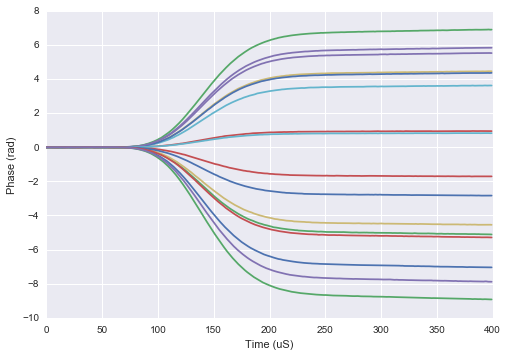

In [12]:
def plotPhaseOfDyn(dyn=0): 
    plt.plot((csi_phase[dyn,:,:])-(csi_phase[0, :,:]));
    plt.xlabel('Time (uS)')
    plt.ylabel('Phase (rad)')
    plt.show()

interact(plotPhaseOfDyn,  dyn=widgets.IntSlider(min=41,max=1499,step=1,value=first_k));

### fit slot to each curve.
Sliding window of 10(?) data points, for all dynanamics, all channels

Now first order derivative

In [15]:
dt = 1e-6 
# slot=np.arange(0,10)
# trajectory = np.zeros_like(csi_phase)[:,:-slot.shape[0],:]
# offset = np.zeros_like(trajectory)
# #for dyn in np.arange(csi.nr_dynamics):
# for ch in np.arange(csi.nr_channels):
#     for idx in np.arange(csi_phase.shape[1]-slot.shape[0]):
#         current_ch = np.transpose(csi_phase[:,slot+idx,ch]) # dyn as second dim
#         fit = np.polyfit((slot+idx)*dt, current_ch,1)
#         offset[:,idx,ch] = fit[1,:]
#         trajectory[:,idx,ch] = fit[0,:]

trajectory = np.diff(csi_phase, axis=1) # radials
meanOffset = np.mean(trajectory[0,:,:], 0)
meanOffset.shape
trajectory = trajectory - meanOffset # radials
trajectory = trajectory / dt / (2*np.pi) / 42.58e6 #  Tesla

In [21]:
def plotTrajectoryOfDyn(dyn=0): 
    plt.plot((trajectory[dyn,:,:]))
    plt.xlabel('Time (uS)')
    plt.ylabel('B (T)')
    plt.show()

interact(plotTrajectoryOfDyn,  dyn=widgets.IntSlider(min=41,max=1499,step=1,value=first_k));

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


### Fit first order gradient set to each dynamic and datapoint

In [17]:
grads = np.zeros([1500, 399, 4])
for idx in np.arange(trajectory.shape[1]):
    grads[:, idx, :] = np.transpose(np.squeeze(linalg.lstsq(shimMatrix, np.transpose(trajectory[:, idx])))[0])
grads = grads*1000 # mT/m

Timing definition of gradients and acquisition
* gradients: +0.1521 ms wrt trigger
* AQ: +0.26 ms wrt trigger
* first 50 μS of data are already removed
* Gr starts at 0.1021 ms = data point 102
* Gr ends at 0.2021 ms = data point 202
* Aq starts at 0.21 ms = data point 210

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


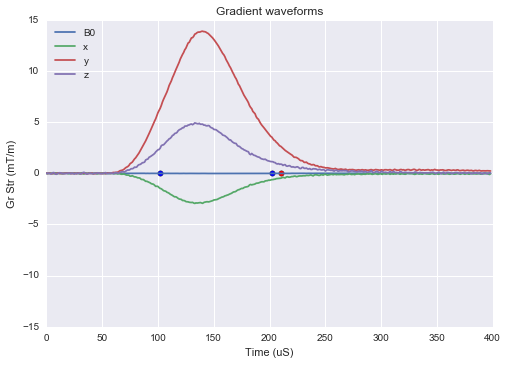

In [18]:
def plotGrad(dyn=0):
    lineObjects = plt.plot(grads[dyn,:,:]);
    plt.scatter(102, 0, s=30);
    plt.scatter(202, 0, s=30);
    plt.scatter(210, 0, s=30, c='r');
    plt.legend(lineObjects, ('B0', 'x', 'y', 'z'), loc='upper left')
    plt.xlim((0,400))
    plt.title('Gradient waveforms')
    plt.xlabel('Time (uS)')
    plt.ylabel('Gr Str (mT/m)')
    plt.ylim((-15,15))
    plt.show();
interact(plotGrad,  dyn=widgets.IntSlider(min=41,max=1499,step=1,value=1198));

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


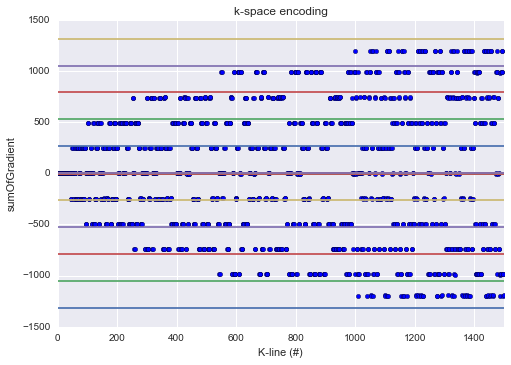

In [19]:
k_location = np.sum(grads, 1)

def getGradientAreaForAxis(ax=0):
    stepsize = 5.2744
    stepfactor = np.arange(-5, 6) 
    if(ax==3):
        stepsize = 4.4632
        stepfactor = np.arange(-6, 7) 
    timeAxis = np.arange(0, 0.05e-3, dt)
    timeAxis = np.append(timeAxis, timeAxis[-2:0:-1])
    amplitude = timeAxis/np.max(timeAxis)
    grAreas = np.zeros_like(stepfactor)
    for idx, fac in enumerate(stepfactor):
        grAreas[idx] = np.sum(amplitude*fac*stepsize)        
    return (grAreas, stepfactor)

def scatterK(ax=0):
#     ax = ax['new']
    if ax=='X': ax=1
    if ax=='Y': ax=2
    if ax=='Z': ax=3
    for grArea in getGradientAreaForAxis(ax):
        plt.plot([0, 1500], [grArea, grArea])
    plt.scatter(np.arange(1500), k_location[:,ax]);
    plt.title('k-space encoding')
    plt.xlabel('K-line (#)')
    plt.ylabel('sumOfGradient')
    plt.xlim((0,1500))
    plt.show()

interact(scatterK, ax=['X','Y','Z']);

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


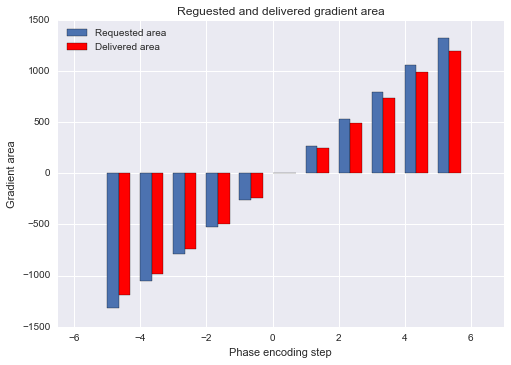

Relative gradient area of X:
phase step: -5 area 90.59180576631259 
phase step: -4 area 93.54838709677419 
phase step: -3 area 93.55246523388116 
phase step: -2 area 93.54838709677419 
phase step: -1 area 93.5361216730038 
phase step: 0 area nan 
phase step: 1 area 93.91634980988593 
phase step: 2 area 93.54838709677419 
phase step: 3 area 93.55246523388116 
phase step: 4 area 93.64326375711575 
phase step: 5 area 90.59180576631259 


In [20]:
def plotHist(ax='X'):
#     ax = ax['new']
    if ax=='X': axis=1
    if ax=='Y': axis=2
    if ax=='Z': axis=3
    grArea, stepfactor = getGradientAreaForAxis(axis)
    diffGrArea = grArea[1]-grArea[0]
    hist = np.digitize(k_location[:,axis], grArea+diffGrArea/2)
    theMeans = np.zeros_like(grArea)
    for idx in np.arange(stepfactor.shape[0]):
        if axis==3 and (idx==0 or idx==12):
            continue
        theMeans[idx] = np.mean(k_location[hist == idx,axis])
    
    np.seterr(divide='ignore',  invalid='ignore') #middle value of grArea is 0
    relativeError = (theMeans/grArea)

    # plot
    width=0.35
    plt.bar(stepfactor, grArea, width=width)
    plt.bar(stepfactor+width, theMeans, color='r', width=width)
    plt.legend(('Requested area', 'Delivered area'), loc='upper left')
    plt.xlabel('Phase encoding step')
    plt.ylabel('Gradient area')
    plt.title('Reguested and delivered gradient area')
    plt.xlim((-6.5, 7))
    plt.show()
    
    
    print("Relative gradient area of {}:".format(ax))
    for idx, relErr in enumerate(relativeError):
        print("phase step: {} area {} ".format(stepfactor[idx], relErr*100))
  
    
interact(plotHist, ax=['X','Y','Z']);